In [ ]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.9/535.9 KB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 7.1 MB/s eta 0:00:00
  Created wheel for causalml: filename=causalml-0.13.0-cp38-cp38-linux_x86_64.whl size=1482398 sha256=933181166c1f62c3380b58a9aa704af2c8d83a128de576cc058eabff6ac4f9c8
  Stored in directory: /root/.cache/pip/wheels/69/88/0f/dacafa2cf04c6eeea7172fb8f4d41b82330f5ec9edf807d167
Successfully built caus

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseRRegressor, BaseXRegressor
from causalml.metrics import plot_gain

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
fdf = pd.read_csv('/content/drive/MyDrive/criteo-uplift-v2.1.csv')

Mounted at /content/drive/


In [ ]:
df = fdf

In [ ]:
print(df.shape)
print(df.treatment.value_counts())
print(df.treatment.value_counts(normalize = True))

(13979592, 16)
1    11882655
0     2096937
Name: treatment, dtype: int64
1    0.85
0    0.15
Name: treatment, dtype: float64


In [ ]:
df.pivot_table(
    values="conversion",
    index="treatment",
    aggfunc=[np.mean, np.size],
    margins=True
)

,mean,size
,conversion,conversion
treatment,,
0,0.001938,2096937
1,0.003089,11882655
All,0.002917,13979592


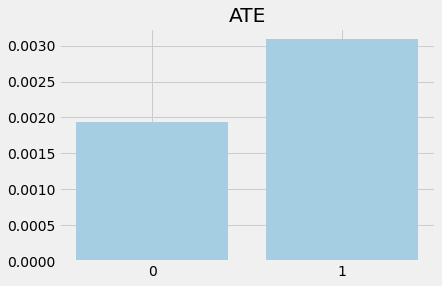

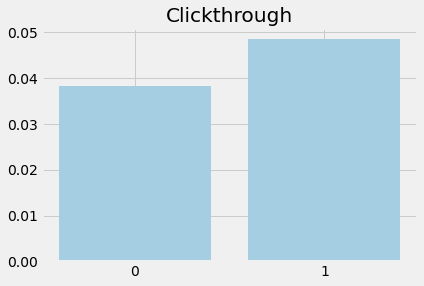

In [ ]:
ate = df.groupby("treatment").conversion.agg(avg_conv=("mean"), sum_conv=("sum"))
plt.bar(x=ate.index, height=ate.avg_conv, tick_label=ate.index)
plt.title("ATE")
plt.show()

click = df.groupby("treatment").visit.agg(avg_click=("mean"))
plt.bar(x=click.index, height=click.avg_click, tick_label=click.index)
plt.title("Clickthrough")
plt.show()

In [ ]:
model_df = df.copy()
model_df["is_treated"] = model_df.treatment
model_df.treatment = np.where(model_df.treatment==1, "treatment", "control")
model_df.drop(columns=["visit", "exposure"], inplace=True)

df_train, df_test = train_test_split(model_df, test_size=0.2, random_state=42)

In [ ]:
uplift_model = UpliftTreeClassifier(control_name='control')
uplift_model.fit(df_train.iloc[:, :12].values,
         treatment=df_train['treatment'].values,
         y=df_train['conversion'].values)
p = uplift_model.predict(df_test.iloc[:, :12].values)

In [ ]:
y_pred = uplift_model.predict(df_test.iloc[:, :12].values)
result = pd.DataFrame(
    y_pred,
    columns=uplift_model.classes_
)
result["delta_treatment"] = result.treatment - result.control
result.head()

,control,treatment,delta_treatment
0,0.001066,0.001132,0.000066
1,0.001066,0.001132,0.000066
2,0.001066,0.001132,0.000066
3,0.001066,0.001132,0.000066
4,0.001066,0.001132,0.000066


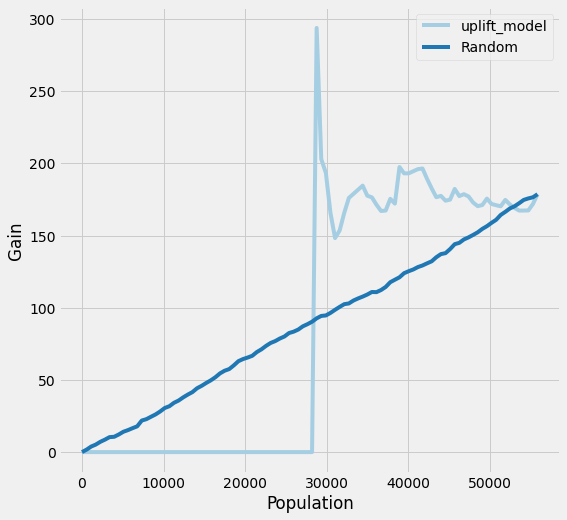

In [ ]:
pred_overview = pd.DataFrame({
    "conversion": df_test.conversion,
    "is_treated": df_test.is_treated,
    "uplift_model": result.delta_treatment
})

plot_gain(pred_overview, outcome_col="conversion", treatment_col="is_treated")
plt.show()

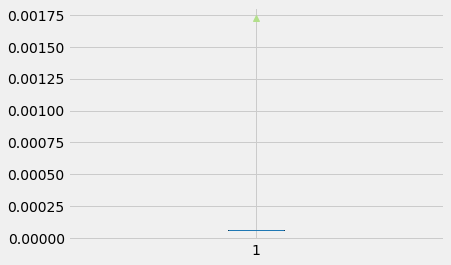

In [ ]:
uplift_dist = plt.boxplot(result.delta_treatment, showfliers=False, showmeans=True)